# Exploratory analysis

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize

from ipywidgets import widgets
from IPython.display import display

import plotly.io as pio
pio.renderers.default = 'notebook'
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns


import plotly.express as px

In [2]:
import sys
sys.path.append('../')

from EnefitModels.src.features import load_data

data = load_data.load_processed_data('../data')

## Questions and Ideas while working:

1. What are the time zones of the different datasets? The weather forecasts explicitly specify a timezone.
2. Outliers in electricity prices: there are some extreme spikes.


### Initial set of regressors
- gas and electricity prices
- eic and installed capacity for points in the client set.

### Explaination for the missing data points in the electricity markets
Are these DST transitions?


## Price data

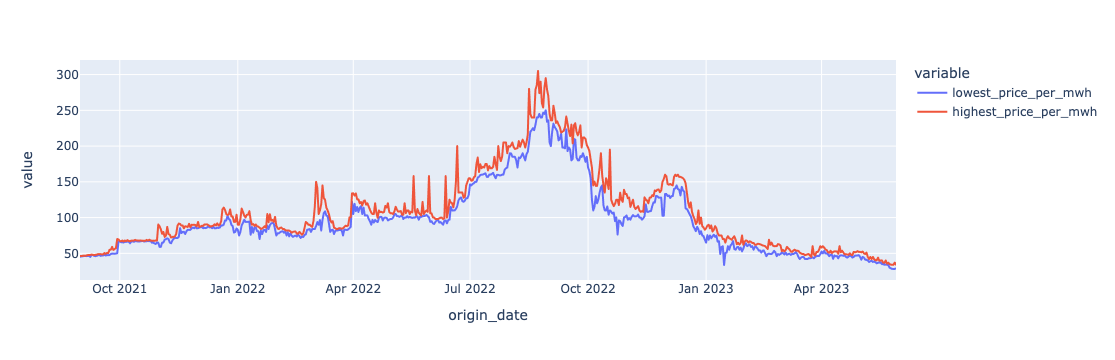

In [4]:
px.line(data.gasPrices, x='origin_date', y=['lowest_price_per_mwh', 'highest_price_per_mwh'])

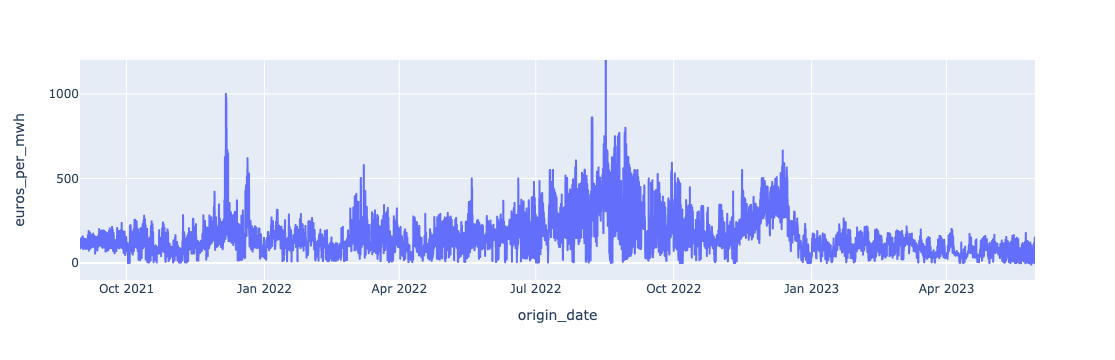

In [6]:
fig = px.line(data.electricityPrices, x='origin_date', y='euros_per_mwh')
fig.update_yaxes(range=[-100, 1200])
fig.show()

<AxesSubplot:title={'center':'Daily electricity prices: mean std dev'}, xlabel='origin_hour', ylabel='euros_per_mwh'>

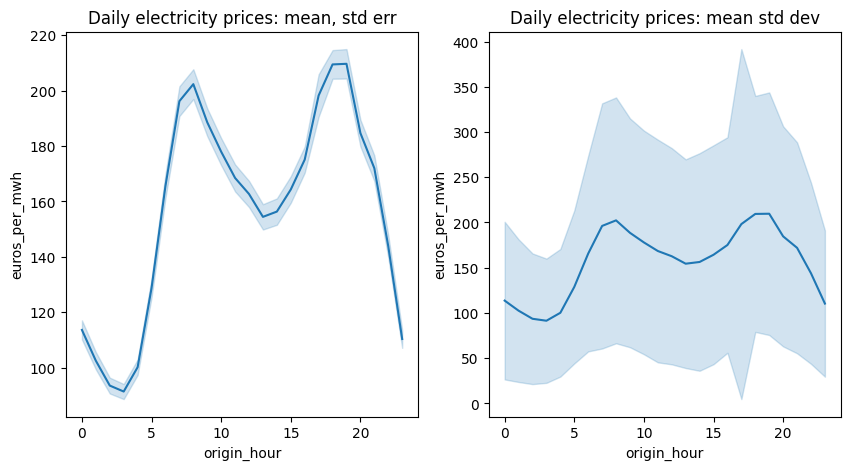

In [8]:
hours = data.electricityPrices.origin_date.dt.hour
hours.name = 'origin_hour'

figsize(10, 5)
plt.subplots(1,2)
plt.subplot(1,2,1)
plt.title('Daily electricity prices: mean, std err')
sns.lineplot(data=pd.concat([data.electricityPrices, hours],axis=1), x='origin_hour', y='euros_per_mwh', errorbar='se')

plt.subplot(1,2,2)
plt.title('Daily electricity prices: mean std dev')
sns.lineplot(data=pd.concat([data.electricityPrices, hours],axis=1), x='origin_hour', y='euros_per_mwh', errorbar='sd')



This is the time-dependence of price with time of day. 
1. The dependence looks reasonable
2. The mean effect is well estimated, even though it is swamped by variance from other factors.

A better way to measure this is the daily time dependence around daily average.

In [16]:
gasMean = (data.gasPrices.set_index('origin_date').lowest_price_per_mwh +
           data.gasPrices.set_index('origin_date').highest_price_per_mwh )/2
gasMean.name = 'gasMean'

gasDiff = (data.gasPrices.set_index('origin_date').highest_price_per_mwh -
           data.gasPrices.set_index('origin_date').lowest_price_per_mwh)
gasDiff.name = 'gasRange'

days = data.electricityPrices.origin_date.dt.date
electricData = data.electricityPrices.groupby(days).agg(electricMean=('euros_per_mwh', 'mean'),
                                                       electricRange=('euros_per_mwh', np.ptp) )

priceComp = pd.concat([electricData, gasMean, gasDiff], axis=1)

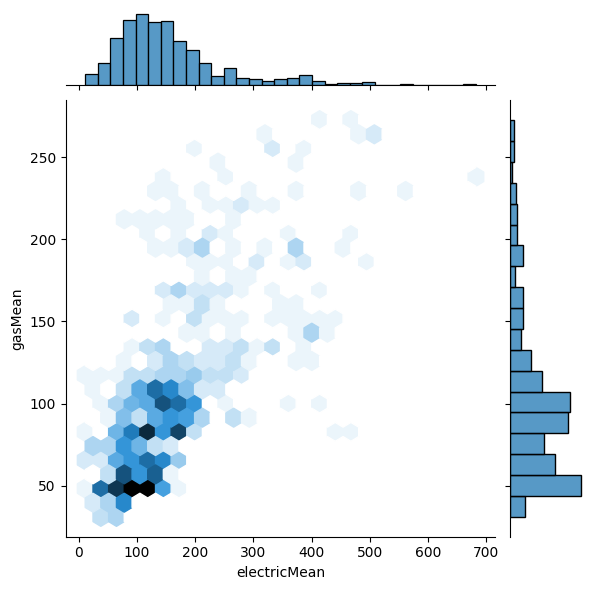

In [54]:
fig = sns.jointplot(data=priceComp, x='electricMean', y='gasMean', kind='hex')
fig.fig.suptitle = 'Daily average electricity and gas prices'

(0.0, 100.0)

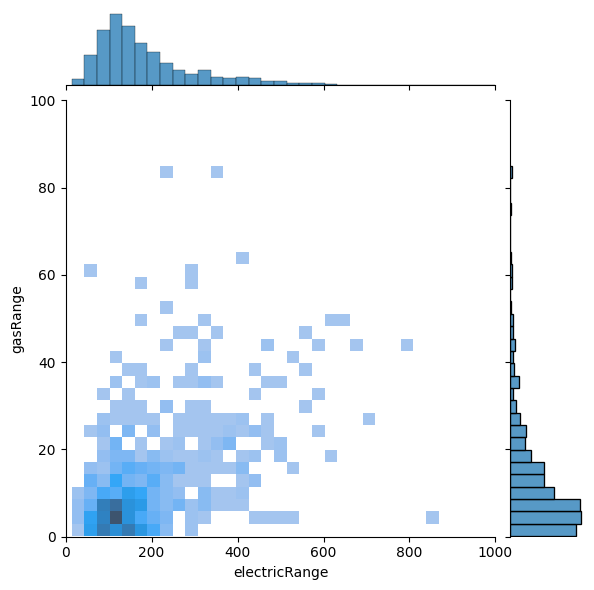

In [52]:
fig = sns.jointplot(data=priceComp, x='electricRange', y='gasRange', kind='hist')
plt.xlim(0, 1000)
plt.ylim(0, 100)

The mean daily prices of electricity and gas are nicely correlated. There is less clear connection between the volatility of gas and electrical prices daily. However, the volatility of electricity is much higher.

## Clients and Training

### Clients

In [3]:
data.clients.head()

,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
0,1,0,108,952.89,0,2021-09-01,2
1,2,0,17,166.40,0,2021-09-01,2
2,3,0,688,7207.88,0,2021-09-01,2
3,0,0,5,400.00,1,2021-09-01,2
4,1,0,43,1411.00,1,2021-09-01,2


<AxesSubplot:xlabel='date', ylabel='installed_capacity'>

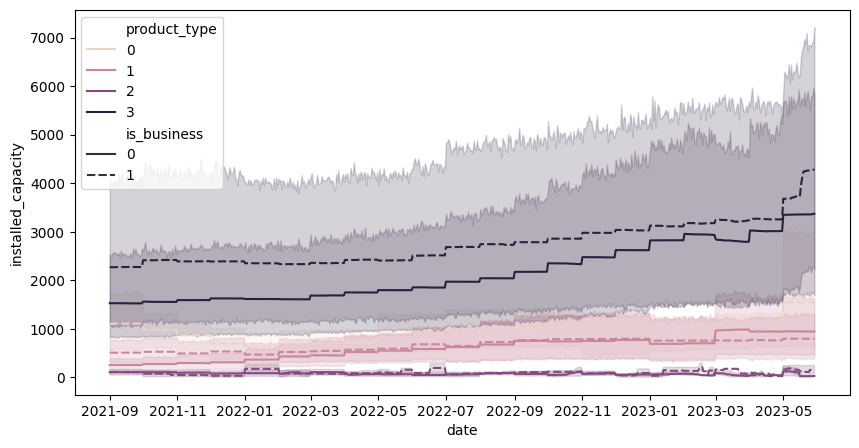

In [71]:
sns.lineplot(data.clients, x='date', y='installed_capacity', hue='product_type', style='is_business')

<AxesSubplot:xlabel='date', ylabel='installed_capacity'>

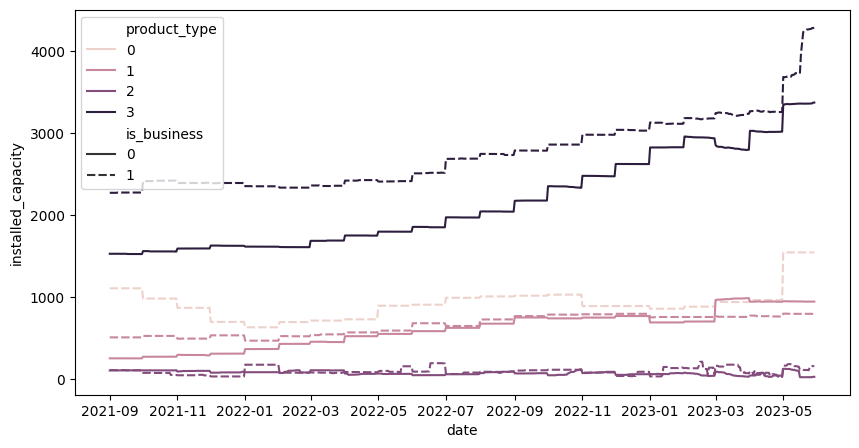

In [69]:
sns.lineplot(data.clients, x='date', y='installed_capacity', hue='product_type', style='is_business', errorbar=None)

Most of the capacity is in product type 3 and for buisnesses. Product 0 appears to be available to buisnesses only.

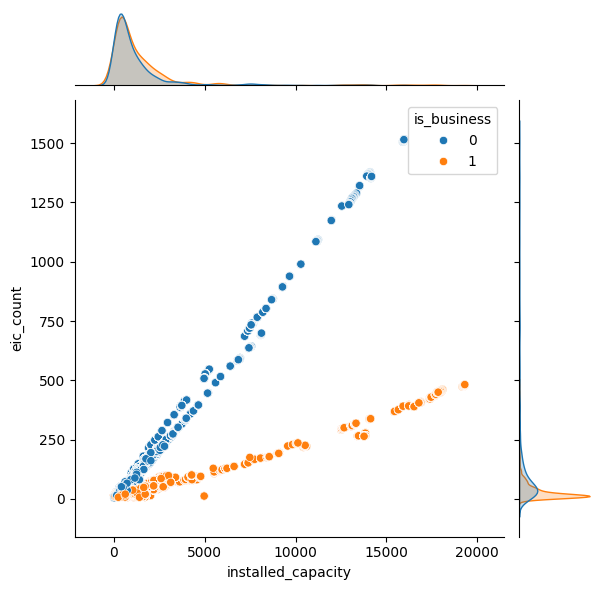

In [76]:
sns.jointplot(data=data.clients, x='installed_capacity', y='eic_count', hue='is_business')

At the very large capacities / eic counts, they correlate very well, with a slope that depends on whether the location is a buisness. However, this represents a very small fraction of the data.

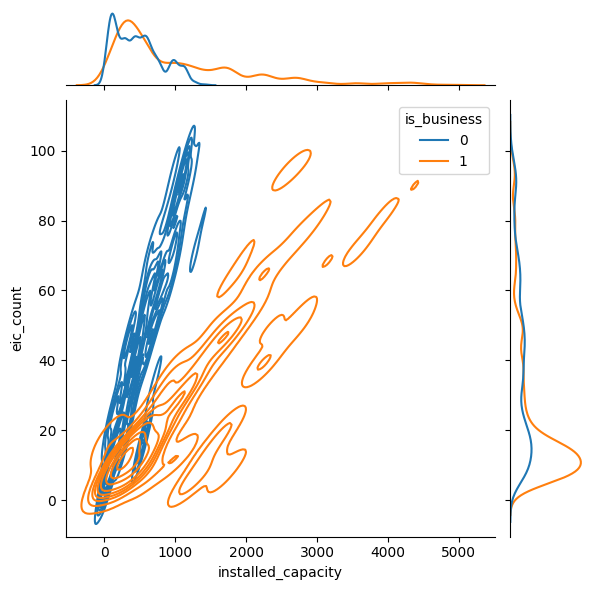

In [97]:
sns.jointplot(data=data.clients[ (data.clients.eic_count < 100) ],
              x='installed_capacity', y='eic_count', hue='is_business', kind='kde')

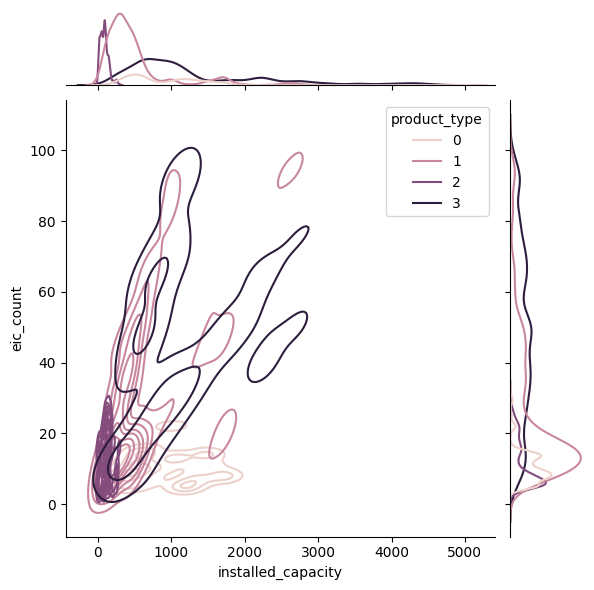

In [95]:
sns.jointplot(data=data.clients[ (data.clients.eic_count < 100) ],
              x='installed_capacity', y='eic_count', hue='product_type', kind='kde')

This relationship seems to hold down into the bulk of the data, and  can resolve product types as well.

<AxesSubplot:xlabel='date', ylabel='installed_capacity'>

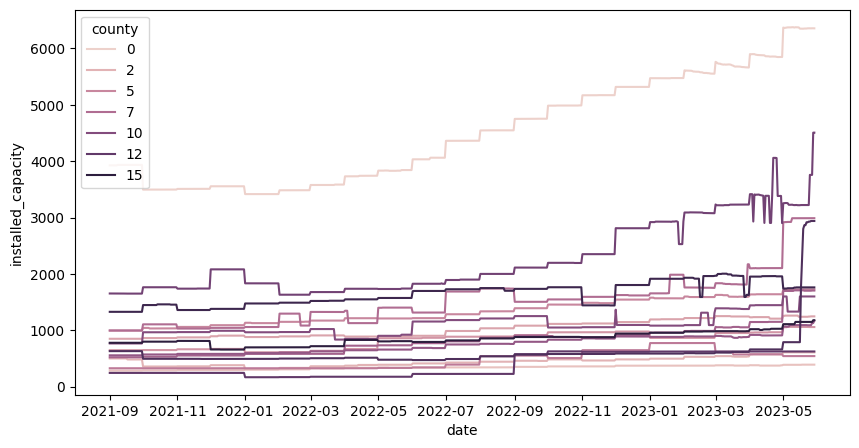

In [139]:
sns.lineplot(data.clients, x='date', y='installed_capacity', hue='county', errorbar=None)

Hard to read much out of the county level data. Except that we know that one county dominates the others.

### Training

In [6]:
data.train.describe()

,county,is_business,product_type,target,is_consumption,data_block_id,row_id,prediction_unit_id
count,2.018352e+06,2.018352e+06,2.018352e+06,2.017824e+06,2018352.0,2.018352e+06,2.018352e+06,2.018352e+06
mean,7.297034e+00,5.368261e-01,1.898927e+00,2.748556e+02,0.5,3.218746e+02,1.009176e+06,3.304538e+01
std,4.780990e+00,4.986421e-01,1.081766e+00,9.095024e+02,0.5,1.826343e+02,5.826482e+05,1.959059e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.000000e+00,0.000000e+00,1.000000e+00,3.780000e-01,0.0,1.660000e+02,5.045878e+05,1.600000e+01
50%,7.000000e+00,1.000000e+00,2.000000e+00,3.113300e+01,0.5,3.230000e+02,1.009176e+06,3.300000e+01
75%,1.100000e+01,1.000000e+00,3.000000e+00,1.802062e+02,1.0,4.790000e+02,1.513763e+06,5.000000e+01
max,1.500000e+01,1.000000e+00,3.000000e+00,1.548027e+04,1.0,6.370000e+02,2.018351e+06,6.800000e+01


In [9]:
data.train.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-08-31 22:00:00+00:00,0,0,0
1,0,0,1,96.590,1,2021-08-31 22:00:00+00:00,0,1,0
2,0,0,2,0.000,0,2021-08-31 22:00:00+00:00,0,2,1
3,0,0,2,17.314,1,2021-08-31 22:00:00+00:00,0,3,1
4,0,0,3,2.904,0,2021-08-31 22:00:00+00:00,0,4,2


I'm curious about seasonality in the training data

<Axes: xlabel='datetime', ylabel='target'>

/usr/local/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



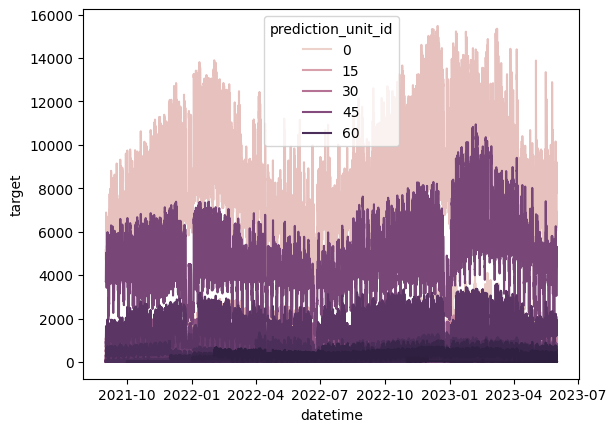

In [12]:
sns.lineplot(data.train[data.train.is_consumption == 1], x='datetime', y='target', hue='prediction_unit_id')

<Axes: xlabel='datetime'>

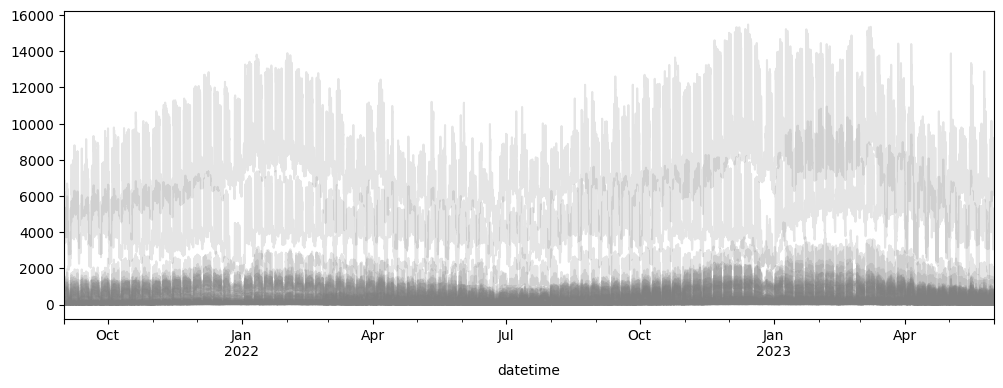

In [29]:
figsize(12, 4)
data.train[data.train.is_consumption == 1].pivot(index='datetime', columns='prediction_unit_id', values='target').plot(legend=False, alpha=0.2, color='gray')

<Axes: xlabel='datetime'>

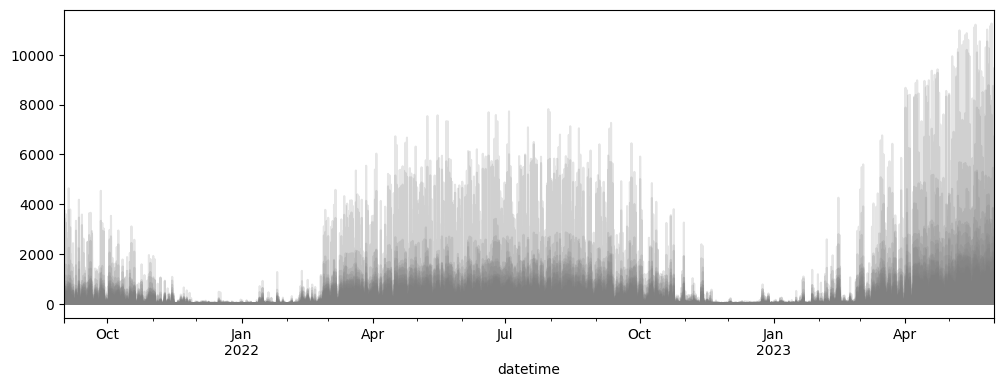

In [30]:
data.train[data.train.is_consumption == 0].pivot(index='datetime', columns='prediction_unit_id', values='target').plot(legend=False, alpha=0.2, color='gray')

Ok, great. We can see that there is strong annual seasonality, as well as other seasonal patterns. I'm sure that there will be weekly, as well as daily effects.

In fact, there are probably effects due to holidays as well.

In [56]:
trainData = pl.from_dataframe(data.train)

In [64]:
# add weekday column
trainData = trainData.with_columns(pl.col('datetime').dt.weekday().alias('weekday'))

<Axes: >

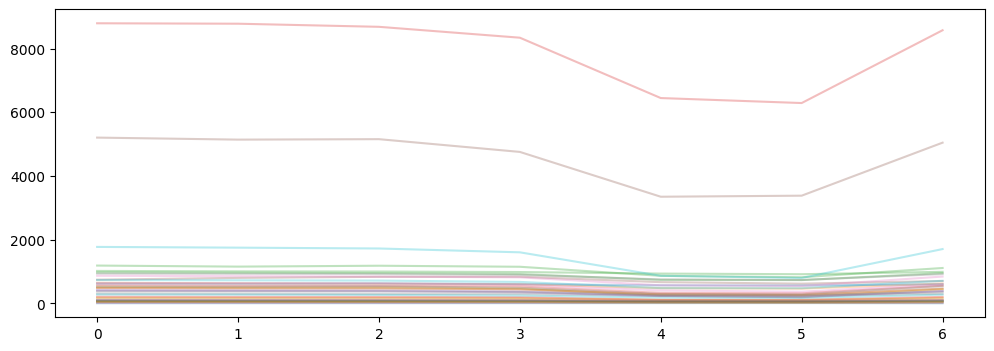

In [80]:
weekdayEffect = trainData.filter( (pl.col('is_consumption') == 1) & (pl.col('is_business') == 1)
                ).pivot(index='weekday', columns='prediction_unit_id', values='target', aggregate_function='mean')
weekdayEffect.to_pandas().plot(legend=False, alpha=0.3)

<Axes: >

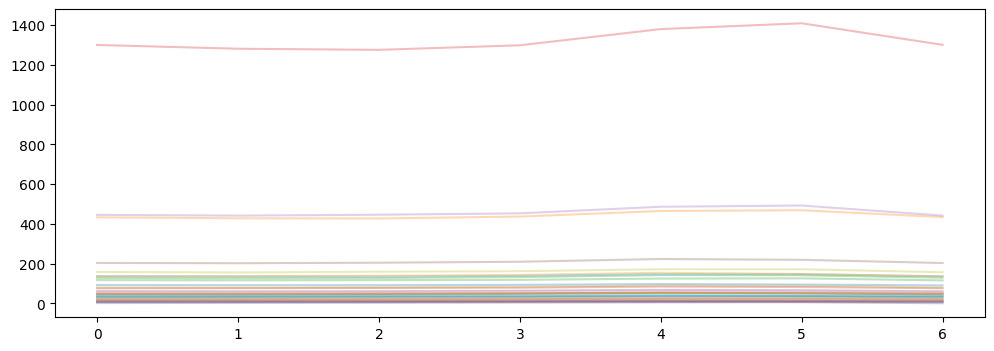

In [81]:
weekdayEffect = trainData.filter( (pl.col('is_consumption') == 1) & (pl.col('is_business') == 0)
                ).pivot(index='weekday', columns='prediction_unit_id', values='target', aggregate_function='mean')
weekdayEffect.to_pandas().plot(legend=False, alpha=0.3)

Indeed, there is an effect of weekday here too. It makes sense that buisnesses would consume less on weekends, while homes consume more. That said, the days don't quite make sense: 4-Thursday, 5-Friday.

#### Can we explain the daily and weekly cycles in terms of the fractions of the max?

The individual prediction units seem to have a shared cycle, but around their own baseline

To what extent does the variance in production correlated with the mean production?

In [75]:
workingTrain = data.train.copy()
workingTrain['date'] = workingTrain.datetime.dt.date
workingTrain['time'] = workingTrain.datetime.dt.time
workingTrain['year'] = workingTrain.datetime.dt.year
workingTrain.drop(columns=['county', 'is_business', 'product_type', 'data_block_id', 'row_id', 'datetime'], inplace=True)

In [92]:
dailyStats = workingTrain.groupby([ 'prediction_unit_id', 'is_consumption', 'date']).agg(
                                                                            daily_min=('target', 'min'),
                                                                            daily_max=('target', 'max'),
                                                                            daily_mean=('target', 'mean'),
                                                                            daily_std=('target', 'std')
                                                                           ).reset_index()

<Axes: title={'center': 'Mean Production'}, xlabel='date'>

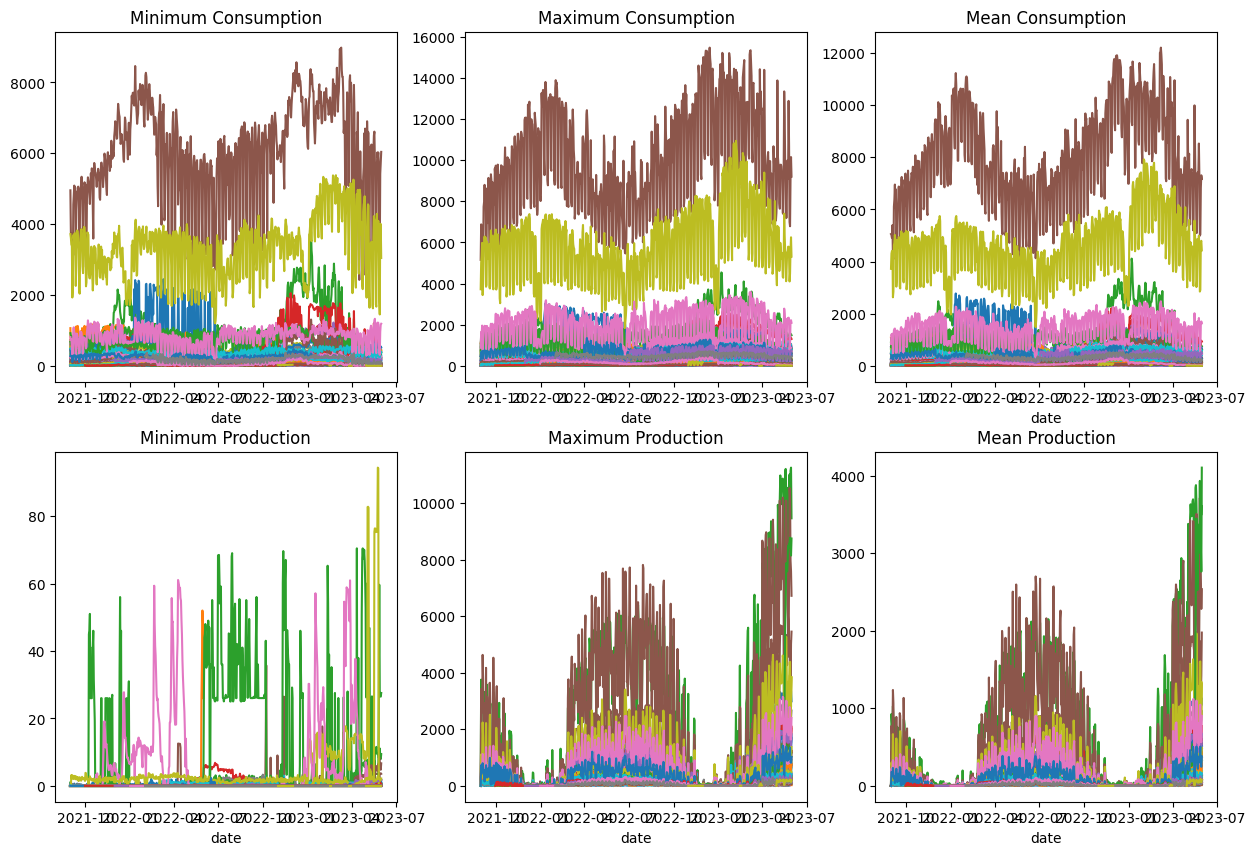

In [126]:
figsize(15, 10)
fig, axes = plt.subplots(2,3)

axes[0, 0].set_title('Minimum Consumption')
axes[0, 1].set_title('Maximum Consumption')
axes[0, 2].set_title('Mean Consumption')

dailyStats[ dailyStats.is_consumption == 1].pivot(index='date', columns='prediction_unit_id', values='daily_min').plot(legend=False, ax=axes[0, 0])
dailyStats[ dailyStats.is_consumption == 1].pivot(index='date', columns='prediction_unit_id', values='daily_max').plot(legend=False, ax=axes[0, 1])
dailyStats[ dailyStats.is_consumption == 1].pivot(index='date', columns='prediction_unit_id', values='daily_mean').plot(legend=False, ax=axes[0, 2])


axes[1, 0].set_title('Minimum Production')
axes[1, 1].set_title('Maximum Production')
axes[1, 2].set_title('Mean Production')

dailyStats[ dailyStats.is_consumption == 0].pivot(index='date', columns='prediction_unit_id', values='daily_min').plot(legend=False, ax=axes[1, 0])
dailyStats[ dailyStats.is_consumption == 0].pivot(index='date', columns='prediction_unit_id', values='daily_max').plot(legend=False, ax=axes[1, 1])
dailyStats[ dailyStats.is_consumption == 0].pivot(index='date', columns='prediction_unit_id', values='daily_mean').plot(legend=False, ax=axes[1, 2])

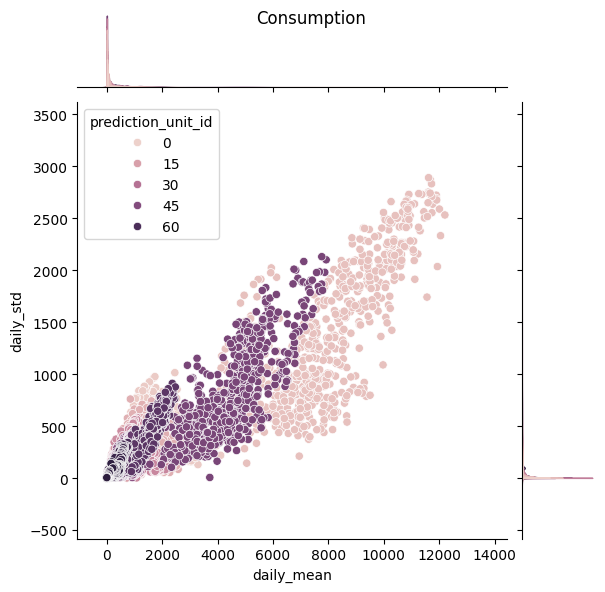

In [164]:
figsize(3,3)

ax = sns.jointplot(data=dailyStats[ dailyStats.is_consumption == 1], x='daily_mean', y='daily_std', hue='prediction_unit_id')
_=ax.fig.suptitle('Consumption')

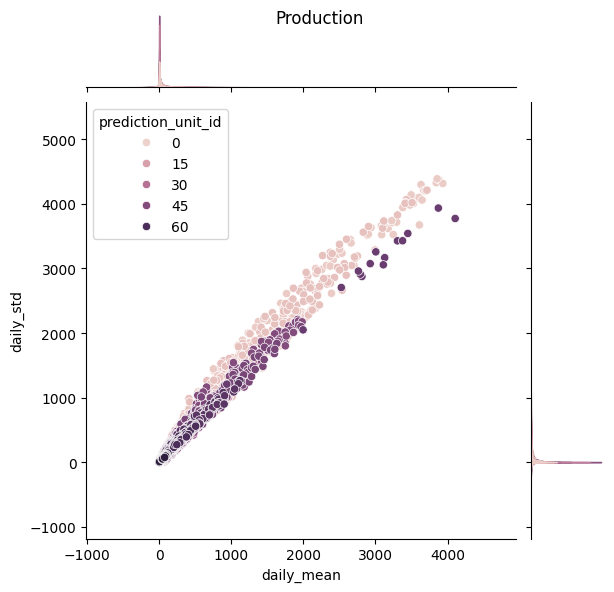

In [165]:
ax = sns.jointplot(data=dailyStats[ (dailyStats.is_consumption == 0)], x='daily_mean', y='daily_std', hue='prediction_unit_id')
_=ax.fig.suptitle('Production')

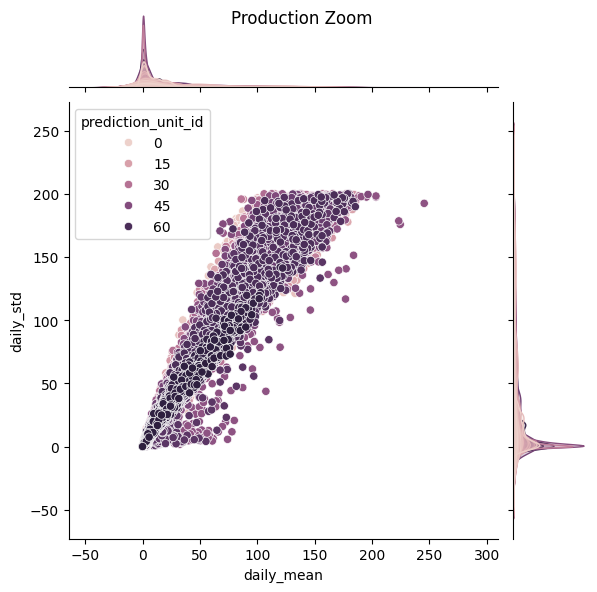

In [166]:
ax = sns.jointplot(data=dailyStats[ (dailyStats.is_consumption == 0) & (dailyStats.daily_std<200)], x='daily_mean', y='daily_std', hue='prediction_unit_id')
_=ax.fig.suptitle('Production Zoom')

Here we see that for both consumption and production, the daily average correlates quite well with the daily standard deviation across days. This is particularly strong for production, even when zooming in on the bulk of the data.

Not a terribly surprising result, since it is essentially a function of installed capacity. However, this does indicated that:
- we should model variation within days _multiplicatively_

__Follow-up__: 
On another note, there is structure in both of these relative to the prediction_unit_id, indicating dependence of the relationship on EIC and is_buisness, maybe even county

In [200]:
unitStats = dailyStats.groupby(['prediction_unit_id', 'is_consumption']).agg(std_of_daily_mean=('daily_mean','std'),
                                             mean_of_daily_mean=('daily_mean', 'mean'),
                                             std_of_daily_max=('daily_max','std'),
                                             mean_of_daily_max=('daily_max','mean')
                                            ).reset_index()



<Axes: title={'center': 'Unit Production'}, xlabel='mean_of_daily_mean', ylabel='std_of_daily_mean'>

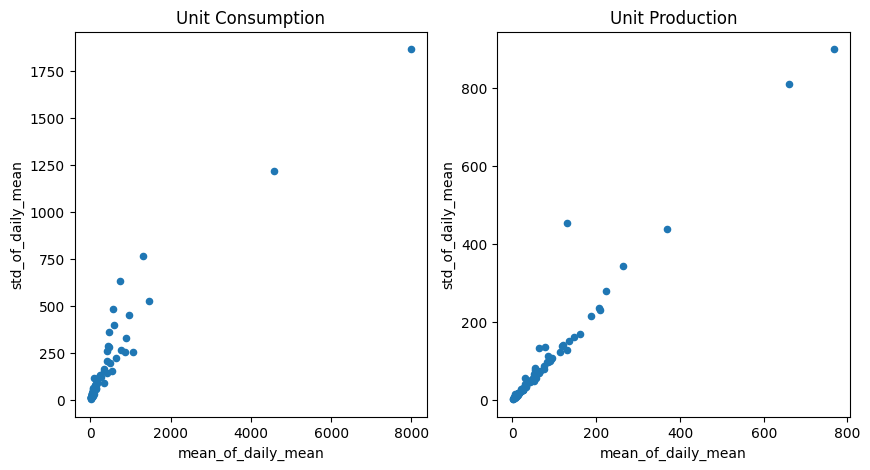

In [201]:
figsize(10, 5)
fig, axes = plt.subplots(1,2)
axes[0].set_title('Unit Consumption')
unitStats[unitStats.is_consumption == 1].plot(x='mean_of_daily_mean', y='std_of_daily_mean', legend=False, kind='scatter', ax=axes[0])

axes[1].set_title('Unit Production')
unitStats[unitStats.is_consumption == 0].plot(x='mean_of_daily_mean', y='std_of_daily_mean', legend=False, kind='scatter', ax=axes[1])

<Axes: title={'center': 'Unit Production - max'}, xlabel='mean_of_daily_max', ylabel='std_of_daily_max'>

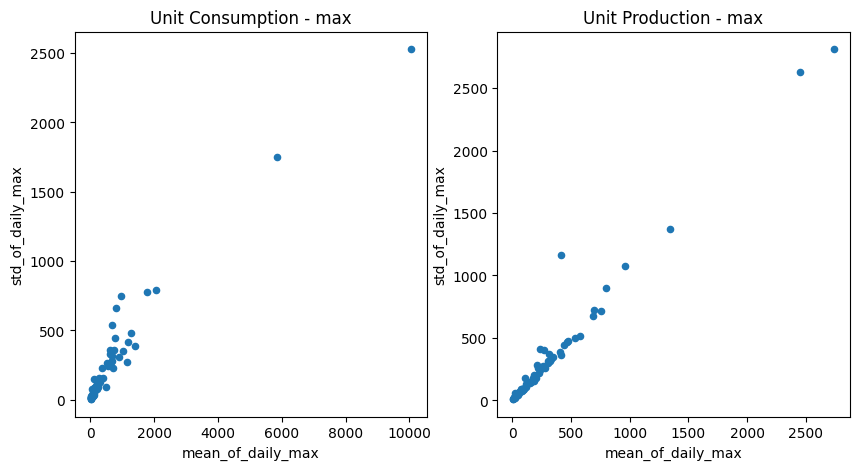

In [203]:
figsize(10, 5)
fig, axes = plt.subplots(1,2)
axes[0].set_title('Unit Consumption - max')
unitStats[unitStats.is_consumption == 1].plot(x='mean_of_daily_max', y='std_of_daily_max', legend=False, kind='scatter', ax=axes[0])

axes[1].set_title('Unit Production - max')
unitStats[unitStats.is_consumption == 0].plot(x='mean_of_daily_max', y='std_of_daily_max', legend=False, kind='scatter', ax=axes[1])

Here we see that a similar effect shows up in variation across days of daily statistics. That is to say, 
- the day-to-day variation should be modeled _multiplicitively_ as well

The same holds for day of the week variation as well.

It seems reasonable that the maximum possible output is predictable by the type of installation

In [45]:
workingTrain = data.train.copy()
workingTrain['date'] = workingTrain.datetime.dt.date

maximumSeen = workingTrain.groupby(
                                ['county', 'is_business', 'product_type', 'is_consumption', 'date', 'prediction_unit_id']
                            ).agg(maxOutput=('target', 'max')).reset_index()

unitStatistics = maximumSeen.merge(data.clients, on=['county', 'is_business', 'product_type', 'date'])

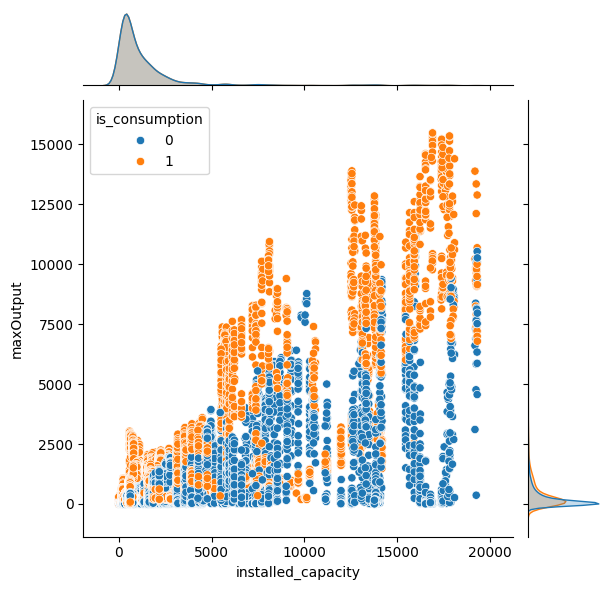

In [46]:
sns.jointplot(data=unitStatistics, x='installed_capacity', y='maxOutput', hue='is_consumption')

Ok, at present, this seems to be swamped by the seasonality in the daily data. Still a reasonable __follow-up__


In [47]:
unitStatistics['prop-to-capacity'] = unitStatistics.maxOutput / unitStatistics.installed_capacity

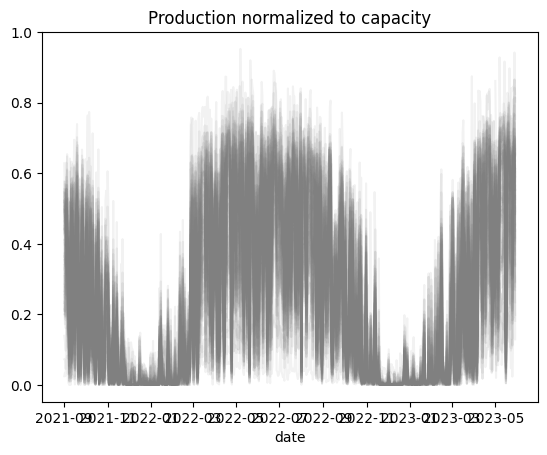

In [70]:
ax = unitStatistics[unitStatistics.is_consumption==0].pivot(
                                                    index='date',
                                                    columns=['prediction_unit_id', 'is_consumption'],
                                                    values='prop-to-capacity'
                                                    ).plot(legend=False, alpha=0.1, color='grey')
_=ax.set_title('Production normalized to capacity')

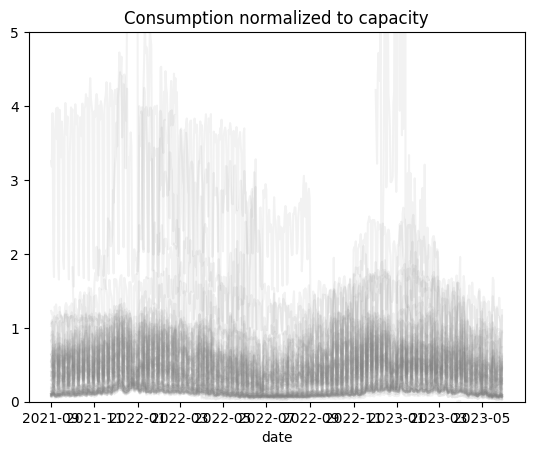

In [73]:
ax = unitStatistics[unitStatistics.is_consumption==1].pivot(
                                                    index='date',
                                                    columns=['prediction_unit_id', 'is_consumption'],
                                                    values='prop-to-capacity'
                                                    ).plot(legend=False, alpha=0.1, color='grey')
_=ax.set_title('Consumption normalized to capacity')
_=ax.set_ylim([0, 5])

Ok. Normalizing the production to installed capacity is really good for tightning the curves together. This is not the case to consumption.
It also works for detrending the production to some extent.

Q: Does production still vary fold wise?

<Axes: xlabel='capacity_normalized_mean', ylabel='capacity_normalized_std'>

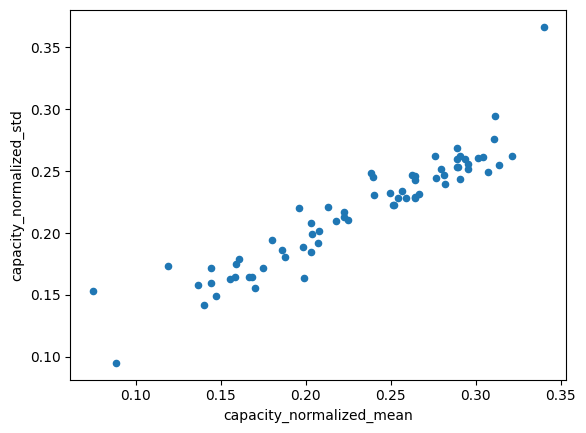

In [79]:
unitStatistics[unitStatistics.is_consumption==0].groupby('prediction_unit_id'
                                                ).agg(capacity_normalized_mean=('prop-to-capacity', 'mean'),
                                                 capacity_normalized_std=('prop-to-capacity', 'std') 
                                                ).plot(x='capacity_normalized_mean',y='capacity_normalized_std', kind='scatter')

Ok. A multiplicative model of the fluctuations is still reasonable.

## Weather

Honestly, my first question is about the timezones that the dates are given in these dateset. The forecasts are in UTC, but what about the historical weather?

Another question is how the locations that we have forecasts / datapoints for relate to the couties that we are predicting?
At some level, I think this is the wrong question to ask a priori because the weather patterns themselves may vary differently between different locations.

Instead, we should be asking how the weather data covaries with different locations.


In [148]:
data.weatherForecast.origin_datetime[0]

Timestamp('2021-09-01 00:00:00+0000', tz='UTC')

In [158]:
data.weatherForecast.forecast_datetime[0]

Timestamp('2021-09-01 01:00:00+0000', tz='UTC')

In [159]:
data.weatherForecast

,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
0,57.6,21.7,2021-09-01 00:00:00+00:00,1,15.655786,11.553613,0.904816,0.019714,0.000000,0.905899,-0.411328,-9.106137,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0
1,57.6,22.2,2021-09-01 00:00:00+00:00,1,13.003931,10.689844,0.886322,0.004456,0.000000,0.886658,0.206347,-5.355405,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0
2,57.6,22.7,2021-09-01 00:00:00+00:00,1,14.206567,11.671777,0.729034,0.005615,0.000000,0.730499,1.451587,-7.417905,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0
3,57.6,23.2,2021-09-01 00:00:00+00:00,1,14.844507,12.264917,0.336304,0.074341,0.000626,0.385468,1.090869,-9.163999,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0
4,57.6,23.7,2021-09-01 00:00:00+00:00,1,15.293848,12.458887,0.102875,0.088074,0.000015,0.176590,1.268481,-8.975766,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3424507,59.7,26.2,2023-05-30 00:00:00+00:00,48,10.150049,5.662744,0.061066,0.257339,0.004059,0.308594,6.890626,-3.258144,637,2023-06-01 00:00:00+00:00,0.0,0.0,0.0,0.0
3424508,59.7,26.7,2023-05-30 00:00:00+00:00,48,10.259790,5.922754,0.107880,0.895203,0.198700,0.906036,6.890626,-3.768032,637,2023-06-01 00:00:00+00:00,0.0,0.0,0.0,0.0
3424509,59.7,27.2,2023-05-30 00:00:00+00:00,48,10.467798,6.072534,0.000000,0.387466,0.448853,0.530518,6.214112,-4.700405,637,2023-06-01 00:00:00+00:00,0.0,0.0,0.0,0.0
3424510,59.7,27.7,2023-05-30 00:00:00+00:00,48,10.694116,7.009058,0.000000,0.505936,0.997314,0.997498,5.810060,-4.338345,637,2023-06-01 00:00:00+00:00,0.0,0.0,0.0,0.0


In [211]:
data.weatherHistorical.duplicated().any()

True